# Primeiro Projeto Bootcamp - Separando os Restaurantes de Niterói por Categoria e Proximidade com o Centro

##### Responsável: Luana Herllain S. Lopes

### Etapa 01 - Instalar e importar as bibliotecas necessárias:

In [1]:
## My Installs

!pip install BeautifulSoup4
!pip install lxml
!pip install geocoder
!pip install seaborn
!pip install wordcloud
!pip install sklearn --upgrade
!pip install folium --upgrade

## My Imports

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import requests ## Used to make requisitions
import geocoder ## Used to capture latitude e longitude from location
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import warnings
warnings.fifilterwarning('ignore')

AttributeError: module 'warnings' has no attribute 'fifilterwarning'

### Etapa 02 - Preparação de parâmetros e funções úteis

In [2]:
# PARAMETROS - API FOURSQUARE

CLIENT_ID = 'AFQ2Z5RTVETYEOOD2LXDGJSD3YCX3Z5GF5IWOBFWE1ZP1DVL' # your Foursquare ID
CLIENT_SECRET = 'SPEQQZQOMD5CG5KCJ3OR1WA4LLZRP2IAZ4TNTBCGOJE2WBVD' # your Foursquare Secret
CODE = '3GBC3450LQJQ1U43UGGGQJLG5PVMO3AGKVTRUTAOGV3SKQ5C#_=_'  # your Foursquare Code
ACCESS_TOKEN = '1LICQRJAH3KYQDLZGWDS1QHKFINWKI3E5221W0KYVMDGYY2U' # your FourSquare Access Token
VERSION = '20211005'
LIMIT = 200
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius  =  3000 

# PARAMETRO - INICIAL FOLIUM

LOCATION_SPEC = '{}, Rio de Janeiro, Niteroi City, BR'
LATITUDE_NITEROI = -22.891372 
LONGITUDE_NITEROI = -43.123991

Your credentails:
CLIENT_ID: AFQ2Z5RTVETYEOOD2LXDGJSD3YCX3Z5GF5IWOBFWE1ZP1DVL
CLIENT_SECRET:SPEQQZQOMD5CG5KCJ3OR1WA4LLZRP2IAZ4TNTBCGOJE2WBVD


In [3]:
## Função de captura de latitude e longitude do bairro 

def get_latlng (neighborhood):
  
  lat_lng_coords = None 
  while (lat_lng_coords is None): 
      g = geocoder.arcgis (LOCATION_SPEC.format (neighborhood)) 
      lat_lng_coords = g.latlng 
  return lat_lng_coords

## Função de captura de detalhes local com API Foursquare 

def get_venues(lat,lng):
  
  #url para buscar dados da API Foursquare
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
          CLIENT_ID, 
          CLIENT_SECRET, 
          VERSION, 
          lat, 
          lng, 
          radius, 
          LIMIT)
  
  # obter todos os dados
  results = requests.get(url).json()
  venue_data = results["response"]['groups'][0]['items']
  venue_details = []
  for row in venue_data:
      try:
          venue_id = row['venue']['id']
          venue_name = row['venue']['name']
          venue_category = row['venue']['categories'][0]['name']
          venue_origin = row['venue']['categories'][0]['shortName']
          venue_latitude = row['venue']['location']['lat']
          venue_longitude = row['venue']['location']['lng']
          venue_details.append([venue_id, venue_name, venue_category, venue_origin, venue_latitude, venue_longitude])
      except KeyError:
          pass
      
  column_names=['ID', 'Name', 'Category', 'Origin', 'Latitude', 'Longitude']
  df = pd.DataFrame(venue_details, columns = column_names)
  print("done!")
  return df

def get_info(id):

  #url para buscar dados da API Foursquare
  url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&v={}&client_secret={}'.format(
          id,
          CLIENT_ID, 
          VERSION, 
          CLIENT_SECRET)

  # obter todos os dados
  result = requests.get(url).json()
  venue_info = result['response']

  return venue_info
  
def return_most_common_venues(row, num_top_venues):

  row_categories = row.iloc[1:]
  row_categories_sorted = row_categories.sort_values(ascending = False)

  return row_categories_sorted.index.values[0:num_top_venues]

### Etapa 03 - Extração de dados de origem

Wikipedia: https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Niter%C3%B3ihttps://pt.wikipedia.org/wiki/Lista_de_bairros_de_Niter%C3%B3i

In [4]:
response = requests.get('https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Niter%C3%B3i')
soup = BeautifulSoup(response.content, 'lxml')
table = soup.find_all('table')[0]
data = pd.read_html(str(table))

source_table = pd.DataFrame(data[0])
source_table

,Região,Nº de bairros,Bairros
0,Praias da Baía,17,Bairro de Fátima • Boa Viagem • Cachoeiras • C...
1,Norte,12,Baldeador • Barreto • Caramujo • Cubango • Eng...
2,Oceânica,11,Cafubá • Camboinhas • Engenho do Mato • Itacoa...
3,Pendotiba,9,Badu • Cantagalo • Ititioca • Largo da Batalha...
4,Leste,3,Muriqui • Rio do Ouro • Várzea das Moças
5,Total,52,NaN


### Etapa 04 - Limpeza e preparação dos dados 
##### IMPORTANTE: É nesta fase que mais trabalharemos e despenderemos mais tempo.

#### 04.1 - Isolando apenas nomes dos bairros de interesse em um DataFrame 

In [5]:
source_table_centro = source_table["Bairros"][0].split(' • ')
df_bairros_centro = pd.DataFrame(source_table_centro, columns = ['Bairros'])

df_bairros_centro

,Bairros
0,Bairro de Fátima
1,Boa Viagem
2,Cachoeiras
3,Centro
4,Charitas
5,Gragoatá
6,Icaraí
7,Ingá
8,Jurujuba
9,Morro do Estado


#### 04.2 - Preparando, Limpando e Classificando com DataFrame (Bairro, Latitude, Longitude e Detalhes)

In [6]:
columns_names = ['Neighborhood', 'Latitude', 'Longitude']
neighborhood_centro_nit = pd.DataFrame(columns = columns_names)

for row in source_table_centro:
  source_table_centro = row
  coords = get_latlng(source_table_centro)
  neighborhood_centro_nit = neighborhood_centro_nit.append({'Neighborhood':source_table_centro, 'Latitude':coords[0], 'Longitude':coords[1]}, ignore_index = True)

neighborhood_centro_nit

,Neighborhood,Latitude,Longitude
0,Bairro de Fátima,-22.89427,-42.46086
1,Boa Viagem,-22.90819,-43.12984
2,Cachoeiras,-22.91099,-43.08039
3,Centro,-22.88543,-43.11789
4,Charitas,-22.92924,-43.09672
5,Gragoatá,-22.90286,-43.13570
6,Icaraí,-22.90425,-43.10570
7,Ingá,-22.90321,-43.12207
8,Jurujuba,-22.93174,-43.11547
9,Morro do Estado,-22.89904,-43.11904


#### 04.3 - Procurando Restaurantes nas Áreas

In [57]:
target = 'Restaurant'
columns_names = ['Neighborhood', 'ID', 'Name', 'Latitude', 'Longitude']
restaurants_centro_nit = pd.DataFrame(columns = columns_names)
count=1

for row in neighborhood_centro_nit.values.tolist():
  Neighborhood, Latitude, Longitude = row
  venues = get_venues(Latitude, Longitude)
  ##restaurants = venues[venues['Category'] == target]
  restaurants = venues[venues['Category'].str.contains(target)]
  print('(',count,'/',len(neighborhood_centro_nit),')', 
        target + ' in ' + 
        Neighborhood + ': ' + 
        str(len(restaurants)))
  
  for detail in restaurants.values.tolist():
    id, name, category, food, lat, lng = detail
    restaurants_centro_nit = restaurants_centro_nit.append({
        'Neighborhood':Neighborhood, 'ID':id, 'Name':name, 
        'Category':category, 'Food':food, 
        'Latitude':lat, 'Longitude':lng}, ignore_index = True)
  count += 1

done!
( 1 / 17 ) Restaurant in Bairro de Fátima: 21
done!
( 2 / 17 ) Restaurant in Boa Viagem: 25
done!
( 3 / 17 ) Restaurant in Cachoeiras: 18
done!
( 4 / 17 ) Restaurant in Centro: 18
done!
( 5 / 17 ) Restaurant in Charitas: 25
done!
( 6 / 17 ) Restaurant in Gragoatá: 19
done!
( 7 / 17 ) Restaurant in Icaraí: 24
done!
( 8 / 17 ) Restaurant in Ingá: 24
done!
( 9 / 17 ) Restaurant in Jurujuba: 18
done!
( 10 / 17 ) Restaurant in Morro do Estado: 21
done!
( 11 / 17 ) Restaurant in Pé Pequeno: 24
done!
( 12 / 17 ) Restaurant in Ponta d'Areia: 12
done!
( 13 / 17 ) Restaurant in Santa Rosa: 20
done!
( 14 / 17 ) Restaurant in São Domingos: 21
done!
( 15 / 17 ) Restaurant in São Francisco: 22
done!
( 16 / 17 ) Restaurant in Viradouro: 17
done!
( 17 / 17 ) Restaurant in Vital Brazil: 21


#### 04.4 - Verificação de dados - Todos os restaurantes

In [58]:
#restaurants_centro_nit = restaurants_centro_nit.drop_duplicates(subset=['ID']).reset_index(drop = True) ## Remove items ID duplicates and reset index
restaurants_centro_nit

,Neighborhood,ID,Name,Latitude,Longitude,Category,Food
0,Bairro de Fátima,53b6d712498e55a100aedf5a,Vila de Melgaço,-22.894490,-43.118678,Portuguese Restaurant,Portuguese
1,Bairro de Fátima,5570ca0f498e88c352d7c7a8,Hashi Sushi,-22.901270,-43.111029,Japanese Restaurant,Japanese
2,Bairro de Fátima,4d9ca4fba1ec8cfa7640f049,Kamilu's,-22.903124,-43.114533,Middle Eastern Restaurant,Middle Eastern
3,Bairro de Fátima,548e2251498ec4125140acc7,Temakeria e Cia,-22.904560,-43.110627,Japanese Restaurant,Japanese
4,Bairro de Fátima,5b1f11c0835c9a002c82a9b0,Abbraccio,-22.896537,-43.124020,Italian Restaurant,Italian
...,...,...,...,...,...,...,...
345,Vital Brazil,4ef890ef61af4546ff34cc7d,Supremo Restaurante,-22.920065,-43.089811,Brazilian Restaurant,Brazilian
346,Vital Brazil,50b6b694582f6c88c6687104,Burger King,-22.901512,-43.112383,Fast Food Restaurant,Fast Food
347,Vital Brazil,4cf1522cd29b2d436fd6f0bb,Restaurante Siri,-22.927153,-43.095607,Seafood Restaurant,Seafood
348,Vital Brazil,4bcb585d511f9521d744b1c7,La Mole,-22.911646,-43.108952,Italian Restaurant,Italian


#### 04.5 - Show Map - All Restaurants

In [59]:
!pip install folium --upgrade

In [55]:
NIT_COORDINATES = [LATITUDE_NITEROI, LONGITUDE_NITEROI]
venues_map = folium.Map(location=[LATITUDE_NITEROI, LONGITUDE_NITEROI], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [LATITUDE_NITEROI, LONGITUDE_NITEROI],
    radius=20,
    color='red',
    popup='Nitéroi',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.0
).add_to(venues_map)

venues_map

In [10]:
NIT_COORDINATES = [LATITUDE_NITEROI, LONGITUDE_NITEROI]
map_nit = folium.Map(location = NIT_COORDINATES, zoom_start = 11)

locations = restaurants_centro_nit[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

print("Number of point(s): " + str(len(location_list)))

for i in range(0, len(location_list)):

  point_name = restaurants_centro_nit['Name'][i]
  point_yard = restaurants_centro_nit['Neighborhood'][i]
  point_category = restaurants_centro_nit['Category'][i]
  point_detail = '<b>' + point_name + '</b><br /><i>' + point_category + ' in '  + point_yard + '</i>'
  
  label = '{}'.format(point_detail)

  if (point_category == 'Restaurant'):
    folium.Marker(
        location_list[i], 
        popup = point_detail, 
        #tooltip = point_detail, 
        icon = folium.Icon(color='red')).add_to(map_nit)
  else:
    folium.Marker(
        location_list[i], 
        popup = point_detail).add_to(map_nit) 
        #tooltip = point_detail

folium.Circle([LATITUDE_NITEROI, LONGITUDE_NITEROI], radius = 20000).add_to(map_nit)
display(map_nit)

Number of point(s): 333


### Como podemos observar um dos bairros está incorreto, trouxe informação de um Bairro que possivelmente possui o mesmo nome em outro município e vamos precisar efetuar a correção deste ponto manualmente, conforme a seguir:

In [54]:
neighborhood_centro_nit.loc[:0]['Longitude'] = -43.11112877590456

neighborhood_centro_nit

<ipython-input-54-4aea4b090159>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighborhood_centro_nit.loc[:0]['Longitude'] = -43.11112877590456


,Neighborhood,Latitude,Longitude
0,Bairro de Fátima,-22.89427,-43.111129
1,Boa Viagem,-22.90819,-43.129840
2,Cachoeiras,-22.91099,-43.080390
3,Centro,-22.88543,-43.117890
4,Charitas,-22.92924,-43.096720
5,Gragoatá,-22.90286,-43.135700
6,Icaraí,-22.90425,-43.105700
7,Ingá,-22.90321,-43.122070
8,Jurujuba,-22.93174,-43.115470
9,Morro do Estado,-22.89904,-43.119040


In [60]:
NIT_COORDINATES = [LATITUDE_NITEROI, LONGITUDE_NITEROI]
map_nit = folium.Map(location = NIT_COORDINATES, zoom_start = 11)

locations = restaurants_centro_nit[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

print("Number of point(s): " + str(len(location_list)))

for i in range(0, len(location_list)):

  point_name = restaurants_centro_nit['Name'][i]
  point_yard = restaurants_centro_nit['Neighborhood'][i]
  point_category = restaurants_centro_nit['Category'][i]
  point_detail = '<b>' + point_name + '</b><br /><i>' + point_category + ' in '  + point_yard + '</i>'
  
  label = '{}'.format(point_detail)

  if (point_category == 'Restaurant'):
    folium.Marker(
        location_list[i], 
        popup = point_detail, 
        #tooltip = point_detail, 
        icon = folium.Icon(color='red')).add_to(map_nit)
  else:
    folium.Marker(
        location_list[i], 
        popup = point_detail).add_to(map_nit) 
        #tooltip = point_detail

folium.Circle([LATITUDE_NITEROI, LONGITUDE_NITEROI], radius = 20000).add_to(map_nit)
display(map_nit)

Number of point(s): 350


#### 04.6 - Verificando Dados - Separando os restaurantes por categoria e localidade

In [61]:
restaurants_category = restaurants_centro_nit.groupby('Food').size().reset_index(name='Count')
restaurants_category

,Food,Count
0,Brazilian,91
1,Comfort Food,3
2,Fast Food,12
3,Italian,82
4,Japanese,57
5,Latin American,5
6,Middle Eastern,12
7,Mineiro,9
8,Mongolian,11
9,Portuguese,25


In [62]:
restaurants_cat_neig = restaurants_centro_nit.groupby(['Food', 'Neighborhood']).size().reset_index(name='Count')
restaurants_cat_neig

,Food,Neighborhood,Count
0,Brazilian,Bairro de Fátima,6
1,Brazilian,Boa Viagem,6
2,Brazilian,Cachoeiras,4
3,Brazilian,Centro,7
4,Brazilian,Charitas,4
...,...,...,...
132,Seafood,São Francisco,3
133,Seafood,Viradouro,1
134,Seafood,Vital Brazil,1
135,Sushi,Cachoeiras,1


#### 04.7 - Resumo

In [63]:
 print('Existem {} categorias únicas.'.format(len(restaurants_centro_nit['Category'].unique())))
 print('Existem {} restaurantes.'.format(len(restaurants_centro_nit['ID'].unique())))

Existem 13 categorias únicas.
Existem 48 restaurantes.


### Etapa 05 - Analisar

In [64]:
# uma hot encoding
neighborhood_onehot = pd.get_dummies(restaurants_centro_nit[['Food']], prefix="", prefix_sep="")
neighborhood_onehot['Neighborhood'] = restaurants_centro_nit['Neighborhood']
fixed_columns = [neighborhood_onehot.columns[-1]] + list(neighborhood_onehot.columns[:-1])
neighborhood_onehot = neighborhood_onehot[fixed_columns]


neighborhood_grouped = neighborhood_onehot.groupby('Neighborhood').mean().reset_index()
neighborhood_grouped

,Neighborhood,Brazilian,Comfort Food,Fast Food,Italian,Japanese,Latin American,Middle Eastern,Mineiro,Mongolian,Portuguese,Restaurant,Seafood,Sushi
0,Bairro de Fátima,0.285714,0.000000,0.047619,0.238095,0.142857,0.000000,0.047619,0.000000,0.047619,0.095238,0.095238,0.000000,0.000000
1,Boa Viagem,0.240000,0.000000,0.040000,0.240000,0.120000,0.040000,0.040000,0.000000,0.040000,0.080000,0.000000,0.160000,0.000000
2,Cachoeiras,0.222222,0.055556,0.000000,0.222222,0.166667,0.055556,0.000000,0.055556,0.000000,0.055556,0.000000,0.111111,0.055556
3,Centro,0.388889,0.000000,0.055556,0.222222,0.166667,0.000000,0.055556,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000
4,Charitas,0.160000,0.040000,0.000000,0.200000,0.080000,0.040000,0.000000,0.040000,0.040000,0.040000,0.080000,0.280000,0.000000
5,Gragoatá,0.315789,0.000000,0.052632,0.157895,0.157895,0.000000,0.052632,0.000000,0.000000,0.105263,0.052632,0.105263,0.000000
6,Icaraí,0.291667,0.000000,0.041667,0.250000,0.166667,0.000000,0.041667,0.041667,0.041667,0.083333,0.000000,0.041667,0.000000
7,Ingá,0.250000,0.000000,0.041667,0.250000,0.125000,0.000000,0.041667,0.000000,0.041667,0.083333,0.000000,0.166667,0.000000
8,Jurujuba,0.222222,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.055556,0.055556,0.000000,0.055556,0.388889,0.000000
9,Morro do Estado,0.285714,0.000000,0.047619,0.285714,0.142857,0.047619,0.047619,0.000000,0.047619,0.095238,0.000000,0.000000,0.000000


In [65]:
num_top_venues = 5

for hood in neighborhood_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = neighborhood_grouped[neighborhood_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Bairro de Fátima----
        venue  freq
0   Brazilian  0.29
1     Italian  0.24
2    Japanese  0.14
3  Portuguese  0.10
4  Restaurant  0.10


----Boa Viagem----
        venue  freq
0   Brazilian  0.24
1     Italian  0.24
2     Seafood  0.16
3    Japanese  0.12
4  Portuguese  0.08


----Cachoeiras----
          venue  freq
0     Brazilian  0.22
1       Italian  0.22
2      Japanese  0.17
3       Seafood  0.11
4  Comfort Food  0.06


----Centro----
        venue  freq
0   Brazilian  0.39
1     Italian  0.22
2    Japanese  0.17
3  Portuguese  0.11
4   Fast Food  0.06


----Charitas----
        venue  freq
0     Seafood  0.28
1     Italian  0.20
2   Brazilian  0.16
3    Japanese  0.08
4  Restaurant  0.08


----Gragoatá----
        venue  freq
0   Brazilian  0.32
1     Italian  0.16
2    Japanese  0.16
3  Portuguese  0.11
4     Seafood  0.11


----Icaraí----
        venue  freq
0   Brazilian  0.29
1     Italian  0.25
2    Japanese  0.17
3  Portuguese  0.08
4   Fast Food  0.04


----Ing

In [66]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# cria colunas de acordo com o número dos principais locais
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Local Mais Comum'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Local Mais Comum'.format(ind + 1))

# criar um novo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhood_grouped['Neighborhood']

for ind in np.arange(neighborhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Local Mais Comum,2nd Local Mais Comum,3rd Local Mais Comum,4th Local Mais Comum,5th Local Mais Comum
0,Bairro de Fátima,Brazilian,Italian,Japanese,Portuguese,Restaurant
1,Boa Viagem,Brazilian,Italian,Seafood,Japanese,Portuguese
2,Cachoeiras,Brazilian,Italian,Japanese,Seafood,Comfort Food
3,Centro,Brazilian,Italian,Japanese,Portuguese,Fast Food
4,Charitas,Seafood,Italian,Brazilian,Japanese,Restaurant
5,Gragoatá,Brazilian,Italian,Japanese,Portuguese,Seafood
6,Icaraí,Brazilian,Italian,Japanese,Portuguese,Fast Food
7,Ingá,Brazilian,Italian,Seafood,Japanese,Portuguese
8,Jurujuba,Seafood,Brazilian,Italian,Japanese,Mineiro
9,Morro do Estado,Brazilian,Italian,Japanese,Portuguese,Fast Food


### Etapa 06 - Analisar (Classificação) 

#### Pergunta: Qual categoria / culinária aparece mais? 

<AxesSubplot:xlabel='count', ylabel='Food'>

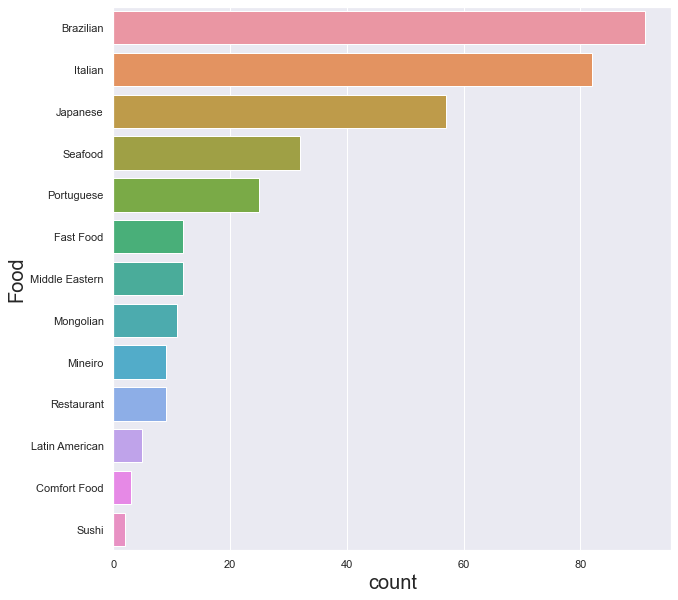

In [67]:
sns.set(rc = {"font.size":20, "axes.titlesize":20, "axes.labelsize":20, 'figure.figsize':(10,10)})
sns.countplot(y = "Food", data = restaurants_centro_nit, order = restaurants_centro_nit['Food'].value_counts().index)

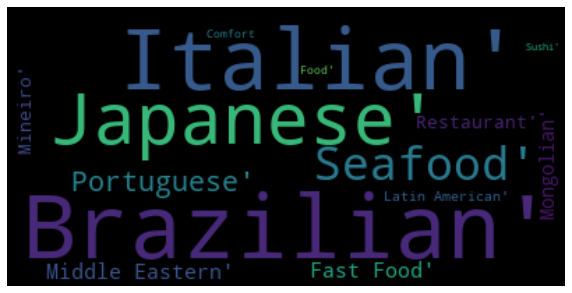

In [68]:
text = restaurants_centro_nit['Food'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Etapa 07 - Analisar (Clusterização) 

#### 07.1 - Visualização de Cluster 

#### Pergunta: Qual é o número de cluster ideal?

In [69]:
K_clusters = range(1, 20)
kmeans = [KMeans(n_clusters = i) for i in K_clusters]
Y_axis = restaurants_centro_nit[['Latitude']]
X_axis = restaurants_centro_nit[['Longitude']]
distances = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

C:\Users\evslo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


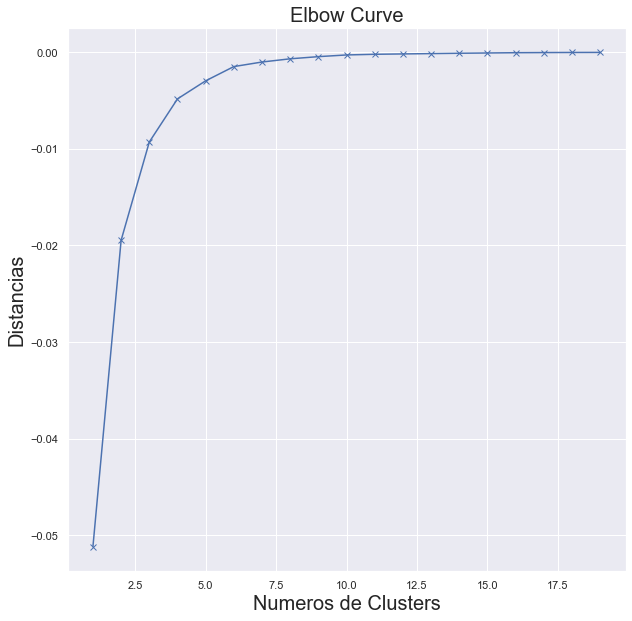

In [70]:
# Visualização
plt.plot(K_clusters, distances,  'bx-')
plt.xlabel('Numeros de Clusters')
plt.ylabel('Distancias')
plt.title('Elbow Curve')
plt.show()

Na análise de cluster, o método de cotovelo é uma heurística usada para determinar o número de clusters em um conjunto de dados. O método consiste em traçar a variação explicada em função do número de clusters e escolher o cotovelo da curva como o número de clusters a usar. No nosso caso, aproximadamente 4,5. Mas usei 4.0.

In [71]:
neighborhood_clustering = restaurants_centro_nit[['Food','Latitude','Longitude','Neighborhood']]
kclusters = 4

kmeans = KMeans(n_clusters = kclusters, init ='k-means++')
kmeans.fit(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
neighborhood_clustering['Cluster Label'] = kmeans.fit_predict(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
neighborhood_clustering

<ipython-input-71-ebe7ada50a17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighborhood_clustering['Cluster Label'] = kmeans.fit_predict(neighborhood_clustering[neighborhood_clustering.columns[1:3]])


,Food,Latitude,Longitude,Neighborhood,Cluster Label
0,Portuguese,-22.894490,-43.118678,Bairro de Fátima,3
1,Japanese,-22.901270,-43.111029,Bairro de Fátima,1
2,Middle Eastern,-22.903124,-43.114533,Bairro de Fátima,1
3,Japanese,-22.904560,-43.110627,Bairro de Fátima,1
4,Italian,-22.896537,-43.124020,Bairro de Fátima,3
...,...,...,...,...,...
345,Brazilian,-22.920065,-43.089811,Vital Brazil,2
346,Fast Food,-22.901512,-43.112383,Vital Brazil,1
347,Seafood,-22.927153,-43.095607,Vital Brazil,2
348,Italian,-22.911646,-43.108952,Vital Brazil,1


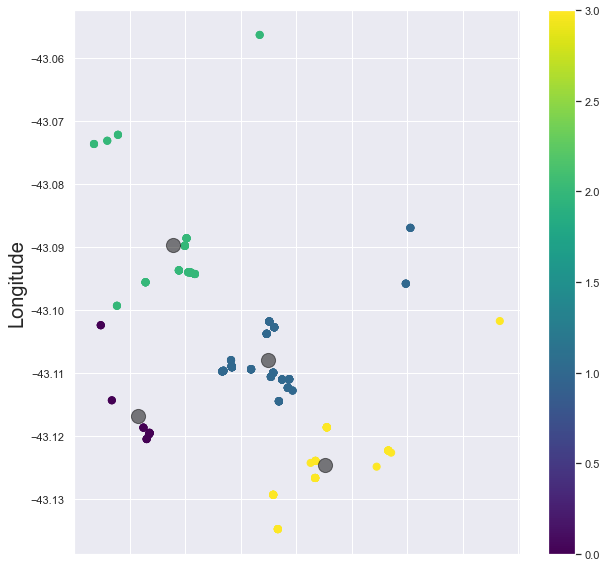

In [72]:
neighborhood_clustering.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s = 50, cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5)

In [73]:
centers = kmeans.cluster_centers_
print(centers)

[[-22.92854419 -43.11680236]
 [-22.90508235 -43.10802412]
 [-22.92228285 -43.08970099]
 [-22.89485898 -43.12471545]]


### Dados de cluster de montagem

In [74]:
neighborhood_clustering = neighborhood_clustering.sort_values(by='Cluster Label', ascending = True).reset_index(drop = True)
neighborhood_clustering

,Food,Latitude,Longitude,Neighborhood,Cluster Label
0,Seafood,-22.926413,-43.119620,Ingá,0
1,Seafood,-22.935218,-43.102437,Jurujuba,0
2,Seafood,-22.933221,-43.114379,Jurujuba,0
3,Seafood,-22.926955,-43.120541,Jurujuba,0
4,Seafood,-22.927531,-43.118722,Boa Viagem,0
...,...,...,...,...,...
345,Brazilian,-22.903316,-43.134858,São Domingos,3
346,Brazilian,-22.904147,-43.129405,Ingá,3
347,Brazilian,-22.904147,-43.129405,São Domingos,3
348,Portuguese,-22.894490,-43.118678,Morro do Estado,3


In [75]:
neighborhood_merged = neighborhood_clustering
neighborhood_merged = neighborhood_clustering.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')
neighborhood_merged = neighborhood_merged.sort_values(by='Cluster Label', ascending = True).reset_index(drop = True)
neighborhood_merged

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Local Mais Comum,2nd Local Mais Comum,3rd Local Mais Comum,4th Local Mais Comum,5th Local Mais Comum
0,Seafood,-22.926413,-43.119620,Ingá,0,Brazilian,Italian,Seafood,Japanese,Portuguese
1,Seafood,-22.935218,-43.102437,São Francisco,0,Italian,Brazilian,Japanese,Seafood,Comfort Food
2,Restaurant,-22.926546,-43.119851,Charitas,0,Seafood,Italian,Brazilian,Japanese,Restaurant
3,Seafood,-22.926433,-43.119550,Ingá,0,Brazilian,Italian,Seafood,Japanese,Portuguese
4,Seafood,-22.926955,-43.120541,Charitas,0,Seafood,Italian,Brazilian,Japanese,Restaurant
...,...,...,...,...,...,...,...,...,...,...
345,Brazilian,-22.896588,-43.126729,São Domingos,3,Brazilian,Italian,Japanese,Portuguese,Fast Food
346,Italian,-22.896537,-43.124020,São Domingos,3,Brazilian,Italian,Japanese,Portuguese,Fast Food
347,Brazilian,-22.904147,-43.129405,Morro do Estado,3,Brazilian,Italian,Japanese,Portuguese,Fast Food
348,Brazilian,-22.904147,-43.129405,Boa Viagem,3,Brazilian,Italian,Seafood,Japanese,Portuguese


### Mostrar mapa - Cluster

In [76]:
# criando mapa
map_clusters = folium.Map(location = NIT_COORDINATES, tiles="cartodbpositron", zoom_start = 11)

# definir esquema de cores para os clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adiciona marcadores ao mapa
markers_colors = []

locations = neighborhood_merged[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

for i in range(0, len(location_list)):

    point_name = neighborhood_merged['Food'][i]
    point_yard = neighborhood_merged['Neighborhood'][i]
    point_cluster = neighborhood_merged['Cluster Label'][i]
    point_detail = '<b>' + point_name + '</b><br /><i> Cluster ' + str(point_cluster) + ' in '  + point_yard + '</i>'

    folium.CircleMarker(
        location_list[i],
        radius = 5,
        popup = point_detail,
        color = rainbow[point_cluster - 1],
        fill = True,
        fill_color = rainbow[point_cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [77]:
## Cluster 1 em Neighbourhood_merged
neighborhood_cluster1 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 0]
neighborhood_cluster1

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Local Mais Comum,2nd Local Mais Comum,3rd Local Mais Comum,4th Local Mais Comum,5th Local Mais Comum
0,Seafood,-22.926413,-43.119620,Ingá,0,Brazilian,Italian,Seafood,Japanese,Portuguese
1,Seafood,-22.935218,-43.102437,São Francisco,0,Italian,Brazilian,Japanese,Seafood,Comfort Food
2,Restaurant,-22.926546,-43.119851,Charitas,0,Seafood,Italian,Brazilian,Japanese,Restaurant
3,Seafood,-22.926433,-43.119550,Ingá,0,Brazilian,Italian,Seafood,Japanese,Portuguese
4,Seafood,-22.926955,-43.120541,Charitas,0,Seafood,Italian,Brazilian,Japanese,Restaurant
5,Seafood,-22.933221,-43.114379,Charitas,0,Seafood,Italian,Brazilian,Japanese,Restaurant
6,Seafood,-22.927531,-43.118722,Charitas,0,Seafood,Italian,Brazilian,Japanese,Restaurant
7,Seafood,-22.926955,-43.120541,Ingá,0,Brazilian,Italian,Seafood,Japanese,Portuguese
8,Seafood,-22.927531,-43.118722,Ingá,0,Brazilian,Italian,Seafood,Japanese,Portuguese
9,Seafood,-22.926433,-43.119550,Charitas,0,Seafood,Italian,Brazilian,Japanese,Restaurant


### Cluster 2

In [78]:
## Cluster 2 em Neighbourhood_merged
neighborhood_cluster2 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 1]
neighborhood_cluster2

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Local Mais Comum,2nd Local Mais Comum,3rd Local Mais Comum,4th Local Mais Comum,5th Local Mais Comum
22,Brazilian,-22.902549,-43.111073,Ponta d'Areia,1,Brazilian,Italian,Japanese,Portuguese,Fast Food
23,Japanese,-22.904853,-43.101845,Bairro de Fátima,1,Brazilian,Italian,Japanese,Portuguese,Restaurant
24,Fast Food,-22.901512,-43.112383,Vital Brazil,1,Japanese,Brazilian,Italian,Fast Food,Middle Eastern
25,Italian,-22.904146,-43.109991,Bairro de Fátima,1,Brazilian,Italian,Japanese,Portuguese,Restaurant
26,Italian,-22.905322,-43.103805,Bairro de Fátima,1,Brazilian,Italian,Japanese,Portuguese,Restaurant
...,...,...,...,...,...,...,...,...,...,...
215,Brazilian,-22.911586,-43.109116,Morro do Estado,1,Brazilian,Italian,Japanese,Portuguese,Fast Food
216,Middle Eastern,-22.903124,-43.114533,Pé Pequeno,1,Brazilian,Italian,Japanese,Portuguese,Fast Food
217,Mongolian,-22.913313,-43.109783,Morro do Estado,1,Brazilian,Italian,Japanese,Portuguese,Fast Food
218,Italian,-22.904146,-43.109991,Pé Pequeno,1,Brazilian,Italian,Japanese,Portuguese,Fast Food


### Cluster 3

In [79]:
## Cluster 3 em Neighbourhood_merged
neighborhood_cluster3 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 2]
neighborhood_cluster3

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Local Mais Comum,2nd Local Mais Comum,3rd Local Mais Comum,4th Local Mais Comum,5th Local Mais Comum
220,Italian,-22.919765,-43.088614,Cachoeiras,2,Brazilian,Italian,Japanese,Seafood,Comfort Food
221,Mineiro,-22.921139,-43.093718,Cachoeiras,2,Brazilian,Italian,Japanese,Seafood,Comfort Food
222,Brazilian,-22.920065,-43.089811,Icaraí,2,Brazilian,Italian,Japanese,Portuguese,Fast Food
223,Portuguese,-22.932118,-43.072156,Cachoeiras,2,Brazilian,Italian,Japanese,Seafood,Comfort Food
224,Seafood,-22.927153,-43.095607,Icaraí,2,Brazilian,Italian,Japanese,Portuguese,Fast Food
...,...,...,...,...,...,...,...,...,...,...
283,Portuguese,-22.932118,-43.072156,São Francisco,2,Italian,Brazilian,Japanese,Seafood,Comfort Food
284,Seafood,-22.927153,-43.095607,São Francisco,2,Italian,Brazilian,Japanese,Seafood,Comfort Food
285,Comfort Food,-22.936439,-43.073619,São Francisco,2,Italian,Brazilian,Japanese,Seafood,Comfort Food
286,Brazilian,-22.920065,-43.089811,São Francisco,2,Italian,Brazilian,Japanese,Seafood,Comfort Food


### Cluster 4

In [80]:
## Cluster 4 em Neighbourhood_merged
neighborhood_cluster4 = neighborhood_merged[neighborhood_merged['Cluster Label'] == 3]
neighborhood_cluster4

,Food,Latitude,Longitude,Neighborhood,Cluster Label,1st Local Mais Comum,2nd Local Mais Comum,3rd Local Mais Comum,4th Local Mais Comum,5th Local Mais Comum
288,Portuguese,-22.894490,-43.118678,Gragoatá,3,Brazilian,Italian,Japanese,Portuguese,Seafood
289,Brazilian,-22.903316,-43.134858,Ingá,3,Brazilian,Italian,Seafood,Japanese,Portuguese
290,Italian,-22.896537,-43.124020,Morro do Estado,3,Brazilian,Italian,Japanese,Portuguese,Fast Food
291,Seafood,-22.897409,-43.124334,Gragoatá,3,Brazilian,Italian,Japanese,Portuguese,Seafood
292,Brazilian,-22.896588,-43.126729,Morro do Estado,3,Brazilian,Italian,Japanese,Portuguese,Fast Food
...,...,...,...,...,...,...,...,...,...,...
345,Brazilian,-22.896588,-43.126729,São Domingos,3,Brazilian,Italian,Japanese,Portuguese,Fast Food
346,Italian,-22.896537,-43.124020,São Domingos,3,Brazilian,Italian,Japanese,Portuguese,Fast Food
347,Brazilian,-22.904147,-43.129405,Morro do Estado,3,Brazilian,Italian,Japanese,Portuguese,Fast Food
348,Brazilian,-22.904147,-43.129405,Boa Viagem,3,Brazilian,Italian,Seafood,Japanese,Portuguese
